# Introduction
Since December 2019, a new coronavirus called 2019-nCoV (Covid-19) has started to spread worldwide. Despite the best efforts to take various measures, including lockdown, vaccines, wearing masks, and social distance, more than 500 million people have been infected with the Covid-19, and more than 6.2 million people have died as a result as of today (Ritchie et al., 2022). The world's population is hoping that the pandemic will end soon, but new variants of the virus are emerging and making Covid-19 even server. In order to reduce the negative impact of the Covid-19 on people's daily lives, most countries are actively increasing Covid-19 vaccination rates in the hope that the vaccine will control and reduce the outbreak. However, does the increase in vaccination rates lower the number of daily confirmed cases of Covid-19?

Due to the unique situation of the pandemic, Covid -19 vaccines have been urgently approved for marketing in several countries. Vaccines for Covid-19 have a shorter development cycle than vaccines for other diseases, and there is a lack of research on their long-term effectiveness (Cyranoski, 2020). Current studies have shown that Covid-19 vaccines are highly effective in preventing severe complications and deaths from Covid-19 in adults, with no serious adverse effects detected in the short term (Henry et al., 2021). Another study noted that a high vaccination rate against Covid-19 will significantly protect all people's health and well-being when vaccination rates exceed 60 percent (Huang et al., 2022). Most people agree that vaccines prevent severe illness and death from Covid-19. However, how they affect the number of confirmed cases over time and the emergence of different variants remains debatable.

This report primarily uses data from the Johns Hopkins University Center for Systems Science and Engineering and from the Our World in Data website own by the University of Oxford to analyze how the vaccination rate against Covid-19 affects the daily case number. It will mainly evaluate whether the increase in vaccination rate has a significant effect on reducing cases number and how large the effect is. In order to get more accurate answers, the report also tries to control for Covid-19 variants, countries, and temperature factors to eliminate the influence of other variables on the number of confirmed cases and minimize the errors in the analysis. At the end of the report, it will also use the data to predict the trend of Covid-19 case numbers for different countries.

# Part One

The dataset includes 280 countries or regions' data from 2020-01-22 to present, in each country and each date, there is the number indicate the cumulative confirmed cases number of Covid-19. Although the dataset is keeping update, in this analysis this report will only use the data from begin to 2022-02-23. The data updated after this date could be used to verify the prediction. 

Below is the code using for data cleaning.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import qeds
import datetime
import geopandas as gpd
import matplotlib.colors as mplc
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm #for linear regression: sm.ols
import seaborn as sns
import requests
import re
import statsmodels.api as sm
import plotly.graph_objects as go
import graphviz
import qeds

from bs4 import BeautifulSoup
from shapely.geometry import Point
from geopandas import GeoDataFrame
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS
from sklearn import tree

%matplotlib inline
qeds.themes.mpl_style();

In [2]:
#Import data from csv file.
df = pd.read_csv(r'G:\UTSG\2022 Winter\ECO225\Project\dataset\csse_covid_19_data\csse_covid_19_time_series\time_series_covid19_confirmed_global.csv')

#Drop column that we don't need.
df.drop(['Lat', 'Long'], axis=1, inplace=True)

#Some of the columns' name have error, filt them and rename them.
for label in df.columns:
    if '2' in label:
        if '200' in label:
            new_label = label[3:]
            df.rename(columns={label: new_label}, inplace=True)
        if '201' in label:
            new_label = label[2:]
            df.rename(columns={label: new_label}, inplace=True)

In [3]:
#Group table by country/region and sum the data in same date for each country/region. Also edit the countries name to match with 
#other dataframe.
all_countries = df.groupby('Country/Region').sum()
all_countries.columns = pd.to_datetime(all_countries.columns)
all_countries.rename({'US':'United States of America', 'Korea, South':'South Korea', 'Bosnia and Herzegovina':'Bosnia and Herz.',
                      'Central African Republic':'Central African Rep.','Congo (Kinshasa)':'Dem. Rep. Congo',
                      'Congo (Brazzaville)':'Congo', "Cote d'Ivoire":"Côte d'Ivoire", 'Dominican Republic':'Dominican Rep.', 
                      'Equatorial Guinea':'Eq. Guinea', 'Eswatini':'eSwatini', 'Solomon Islands':'Solomon Is.', 
                      'South Sudan':'S. Sudan', 'Taiwan*':'Taiwan'}, inplace=True)
all_countries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, Afghanistan to Zimbabwe
Columns: 744 entries, 2020-01-22 to 2022-02-03
dtypes: int64(744)
memory usage: 1.1+ MB


After cleaning the data, this report keep 196 countries or regions and 744 days of observational data. Because there are too many countries or regions in the dataset, this report will choose some of them with classic features to represent the other countries. Hence, this report sorts the data by the most recent confirmed cases number and plot the graph to see the overall tendency.

In [4]:
#Sort the data based on recent confirmed case number, from high to low.
top_10 = all_countries.sort_values('2/3/22', ascending=False).head(10)
top_10.columns.name = 'date'
top_10 = top_10.T

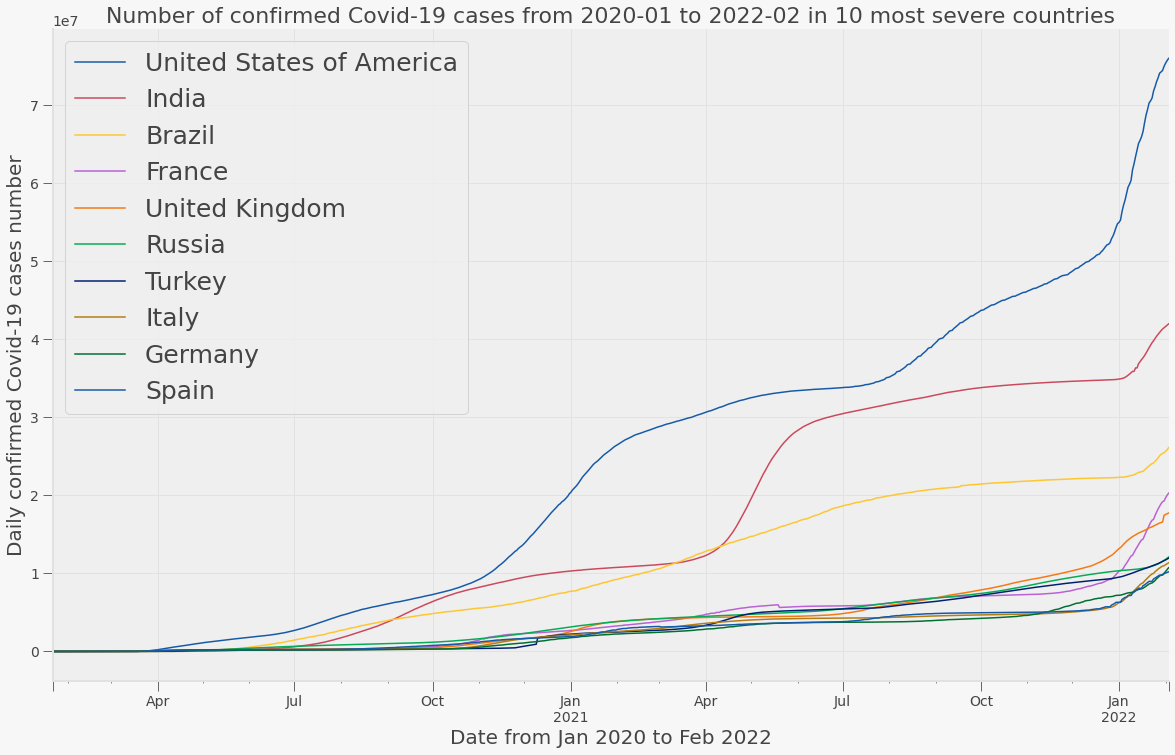

In [5]:
fig, ax = plt.subplots(figsize=(20,12))
top_10.plot.line(ax=ax)
ax.set_xlabel('Date from Jan 2020 to Feb 2022', fontsize=20)
ax.set_ylabel('Daily confirmed Covid-19 cases number', fontsize=20)
ax.set_title('Number of confirmed Covid-19 cases from 2020-01 to 2022-02 in 10 most severe countries', fontsize=22)
ax.legend(fontsize=25)

In this plot, the independent variable x is time and country/region, and the dependent variable y is the confirmed case number.

We found that the US, India, Brazil, France, UK, Russia, Turkey, Italy, Germany, and Spain belong to the top 10. Most of them have a similar trending pattern except the US, India, and Brazil have an extremely increased confirmed cased. Generally, the number of confirmed cases in all these countries increased over time and started to show a significant increase in December 2021. This trend is consistent with what we know about the Covid-19 variant of the virus Omicron, which is spreading faster and with greater intensity. This means that in these countries/regions, different locations, demographic information, and geographic information do not affect the Covid-19 spreading pattern, so this report could use some of the countries to represent the overall tendency.

Besides, this report also want to check if the countries have the most confirmed cases number at the beginning of the pandemic, which means the countries that were first affected when the covid-19 outbreak began, have a different pattern. So we will plot another graph to see.

Notice that because the pandemic is not fully spread in the first few months, it is hard to say which countries have the fastest spread speed. So I will check the cumulative cased number in the first quarter in 2020 instead. Also, for the convenience of the following analysis, I will create a new dataframe that contains non-cumulative daily cases number in each country.

In [6]:
#Create a new dataframe contains the daily confirmed cases number.
all_daily = all_countries.T.diff()
all_daily = all_daily.T
all_daily[pd.to_datetime('2020-01-22')] = all_countries[pd.to_datetime('2020-01-22')]

#Replace some error value.
for time in all_daily.columns:
    for country in all_daily.index:
        if all_daily[time][country] < 0:
            all_daily.at[country, time] = 0

#Group daily confirmed numbers by quarter.
all_daily_T = all_daily.T
all_gbqt = all_daily_T.groupby(pd.Grouper(freq='Q')).sum()
all_gbqt = all_gbqt.T

In [7]:
#Sort the data based on confirmed case number in 2020 first quater, from high to low.
top_10_2020_qt = all_gbqt.sort_values(pd.to_datetime('3/31/20'), axis=0, ascending=False).head(10)
top_10_2020_qt = top_10_2020_qt.T

#Get the full dafa from top 10 cases countries.
top10_2020_days = pd.DataFrame()
for name in top_10_2020_qt.T.index:
    top10_2020_days[name] = (all_countries.T[name])

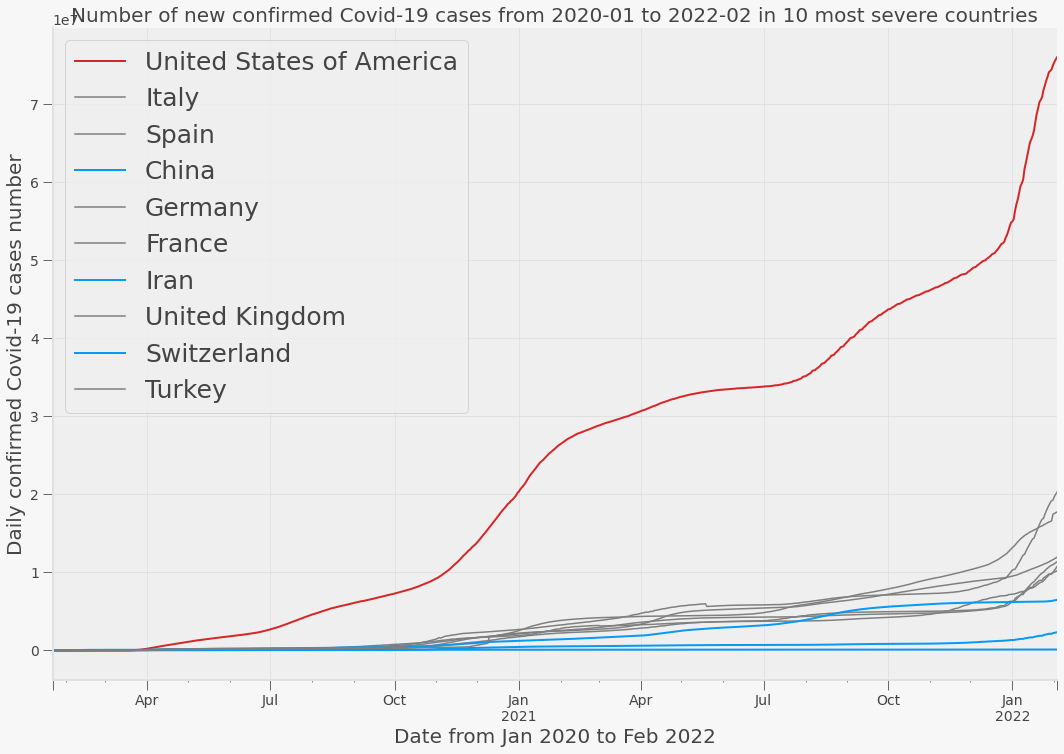

In [8]:
fig, ax = plt.subplots(figsize=(18,12))

emph_color = '#d62728'
sec_color = '#069af3'
other_color = '#7f7f7f'

for country in top10_2020_days.columns:
    if country == 'United States of America':
        top10_2020_days[country].plot(ax=ax, legend=True, color=emph_color, linewidth=2.0)
    elif country in ['China', 'Iran', 'Switzerland']:
        top10_2020_days[country].plot(ax=ax, legend=True, color=sec_color, linewidth=2.0)
    else:
        top10_2020_days[country].plot(ax=ax, legend=True, color=other_color, linewidth=1.5)

ax.set_xlabel('Date from Jan 2020 to Feb 2022', fontsize=20)
ax.set_ylabel('Daily confirmed Covid-19 cases number', fontsize=20)
ax.set_title('Number of new confirmed Covid-19 cases from 2020-01 to 2022-02 in 10 most severe countries', fontsize=20)
ax.legend(fontsize=25)

In this plot, we found that China, Iran, and Switzerland had a very high number of confirmed cases at the beginning of the pandemic. However, as time has passed, the number of confirmed cases in these countries has decreased significantly and shows a different pattern with other countries. Other countries have been in the top 10 for confirmed cases since the beginning of the pandemic till the present. On the other hand, India, Brazil, and Russia, which started relatively uninfected, now have become the countries with the highest number of confirmed cases. We are curious about the different pattern, and want to explore if the vaccination rate affects that.

# Project 2

## The Message for Project 2

As the vaccine rate increases, after the first two months of the emergence of new Covid-19 variants, there is a downward trend in the number of confirmed cases, which means that the increase in vaccination rates is likely to be effective in reducing the number of cases.

I choose to use the the vaccination rate and confirmed cases number in United States as my message plot, but due to the coding order, please see the plot at the end of part 2.

## Detailed plot

In [9]:
#Define the countries we want to research.
rsch_countries = ['China', 'Switzerland', 
                  'United States of America', 'United Kingdom', 
                  'India', 'Russia']

#Create a dataframe contains only the data from research countries.
per_day = pd.DataFrame()
for country in rsch_countries:
    per_day[country] = all_daily.T[country]

per_day = per_day.T
for date in per_day.columns:
    if date < pd.to_datetime('2020-9-15'):
        per_day.drop(date, axis=1, inplace = True)

per_day = per_day.T
per_week = per_day.groupby(pd.Grouper(freq='W')).sum()

per_week.reset_index(inplace=True)

In [10]:
#Import vaccination data from csv file.
vacc = pd.read_csv(r'G:\UTSG\2022 Winter\ECO225\Project\dataset\vaccination\country_vaccinations.csv')
vacc['date'] = pd.to_datetime(vacc['date'])
vacc.loc[vacc['country'] == 'United States', 'country'] = 'United States of America'
vacc.fillna(method="ffill", inplace=True)

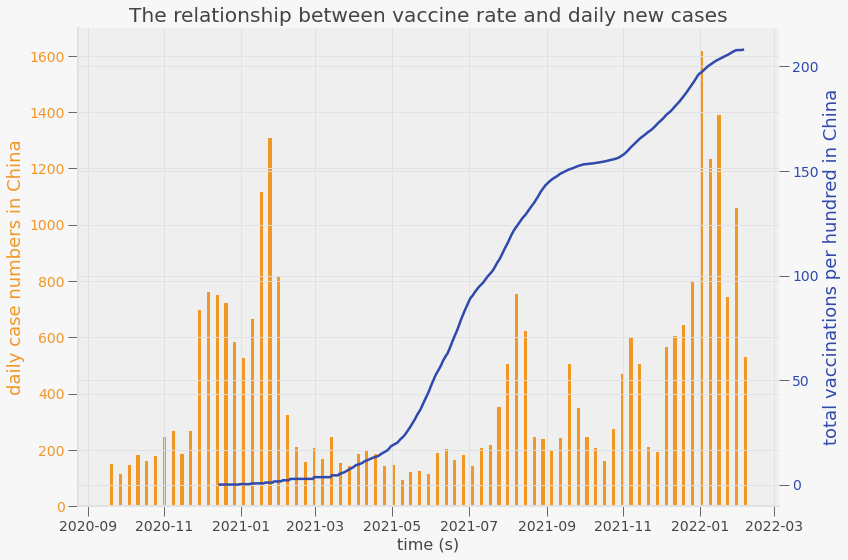

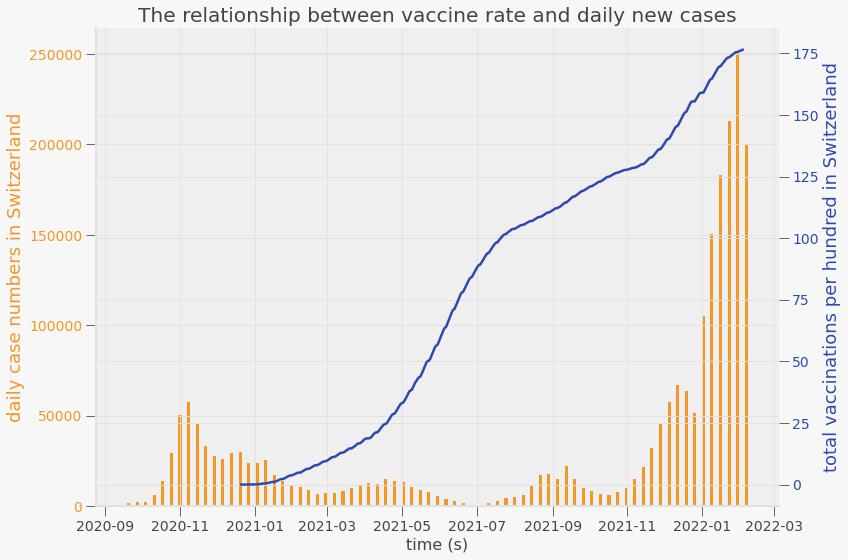

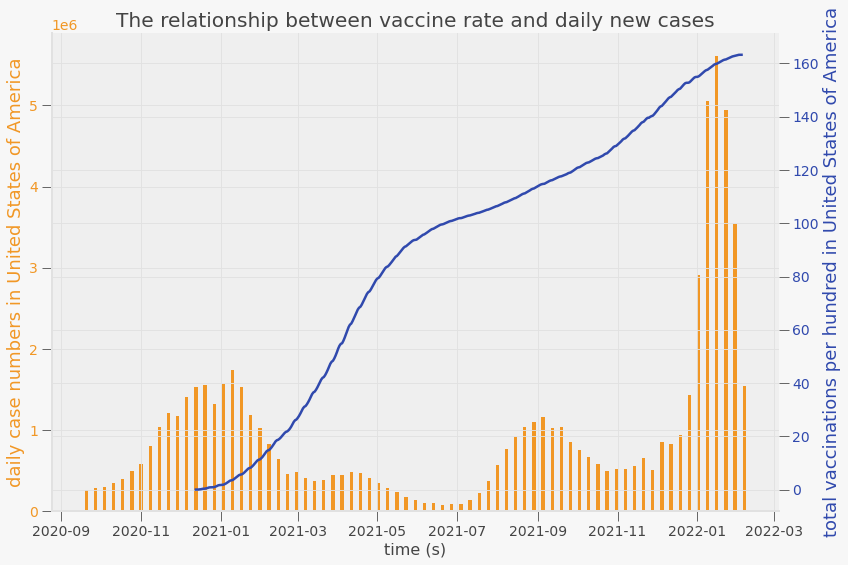

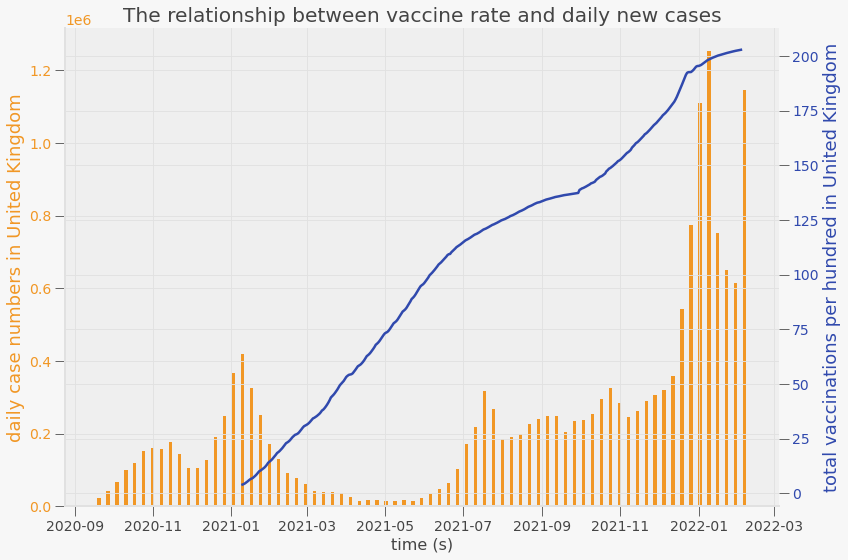

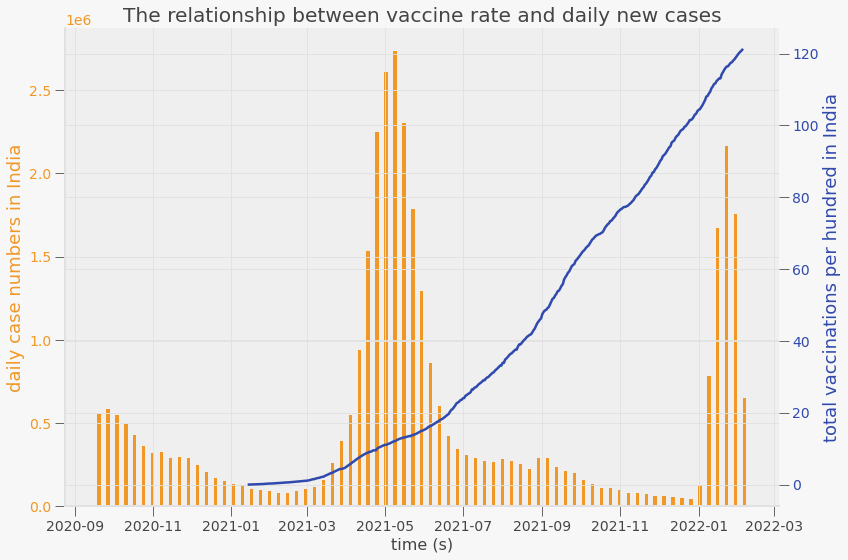

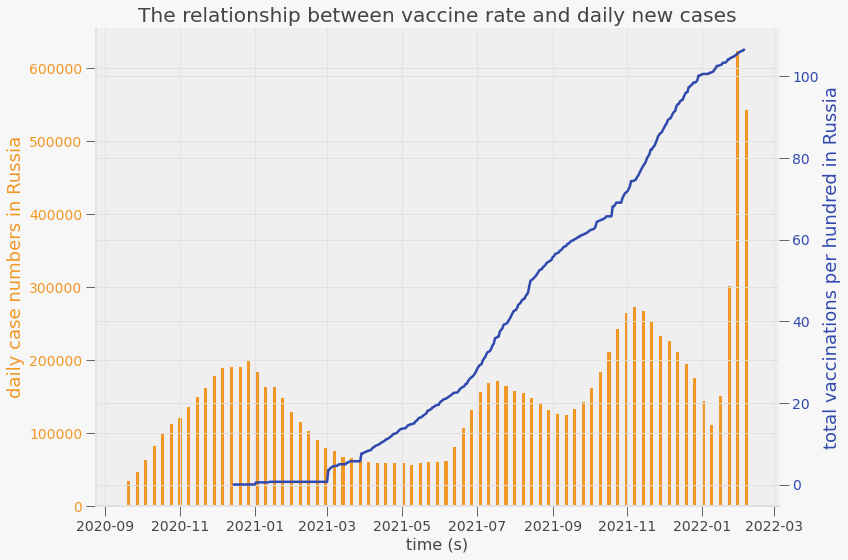

In [11]:
for country in rsch_countries:
    fig, ax1 = plt.subplots(figsize=(12, 8))

    color = '#f19725'
    ax1.set_xlabel('time (s)', fontsize=16)
    ax1.set_ylabel('daily case numbers in ' + country, color=color, fontsize=18)
    ax1.bar(per_week['date'], per_week[country], color=color, width=2.5)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax1.set_title('The relationship between vaccine rate and daily new cases')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = '#3049ad'

    x = vacc.loc[vacc['country'] == country, 'date']
    y = vacc.loc[vacc['country'] == country, 'total_vaccinations_per_hundred']
  

    ax2.set_ylabel('total vaccinations per hundred in ' + country, color=color, fontsize=18)  # we already handled the x-label with ax1
    ax2.plot(x, y, color=color, linewidth=2.5)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()

    plt.show()

Because both vaccination rate and the daily confirmed cases number are time series data, we plot them in one figure for each researched country. In these graphs, the X variable is time, and the Y variable is the number of confirmed cases per day and the number of vaccinations per 100 people. We can observe the trend and correlation between the two Y variables in the graph.

Based on vaccine rates and daily new confirmed cases in several representative countries, we found that the number of confirmed cases declined over some period of time as vaccine rates increased. Specifically, the number of confirmed cases declined significantly after January-March 2020, May-July 2020, September-November 2020, and February 2022, taking the US as an example. According to the World Health Organization, December 2020 to January 2021, April-May 2021, and November 2021 to January 2022 produced the Gamma, Delta, and Omicron variants, respectively. New variants may affect the vaccine's effectiveness, so this short-term increase is understandable.

At the same time, this report has noticed that after the emergence of the Omicron variant, the number of confirmed cases in each country has increased significantly. This may mean that the vaccine is least effective against Omicron. Meanwhile, China has seen a significant drop in the number of confirmed cases since January 2022, reducing the infection rate at Omicron faster than in other countries. This particular pattern may be linked to other factors, such as quarantine and lockdown policies.

## Main Message plot

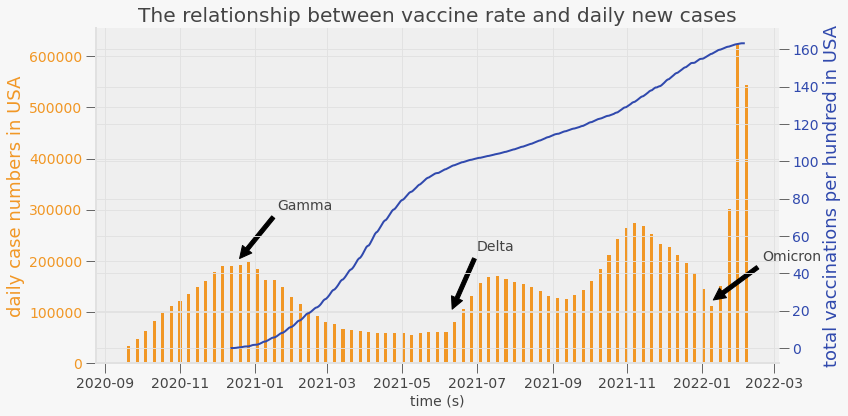

In [12]:
fig, ax1 = plt.subplots(figsize=(12, 6))
color = '#f19725'
ax1.set_xlabel('time (s)', fontsize=14)
ax1.set_ylabel('daily case numbers in USA', color=color, fontsize=18)
ax1.bar(per_week['date'], per_week[country], color=color, width=2.5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('The relationship between vaccine rate and daily new cases')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = '#3049ad'
x = vacc.loc[vacc['country'] == 'United States of America', 'date']
y = vacc.loc[vacc['country'] == 'United States of America', 'total_vaccinations_per_hundred']

ax2.set_ylabel('total vaccinations per hundred in USA', color=color, fontsize=18)  # we already handled the x-label with ax1
ax2.plot(x, y, color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

ax1.annotate('Omicron', xy=(pd.to_datetime('2022-01-08'), 120000), xytext=(pd.to_datetime('2022-2-19'), 200000),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax1.annotate('Gamma', xy=(pd.to_datetime('2020-12-18'), 200000), xytext=(pd.to_datetime('2021-1-19'), 300000),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax1.annotate('Delta', xy=(pd.to_datetime('2021-06-10'), 100000), xytext=(pd.to_datetime('2021-7-1'), 220000),
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

## The Map

In [13]:
# Grab low resolution world file
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("name")

all_gbqt_map = all_gbqt.copy()
all_gbqt_map['geometry'] = world['geometry']
all_gbqt_map = GeoDataFrame(all_gbqt_map)

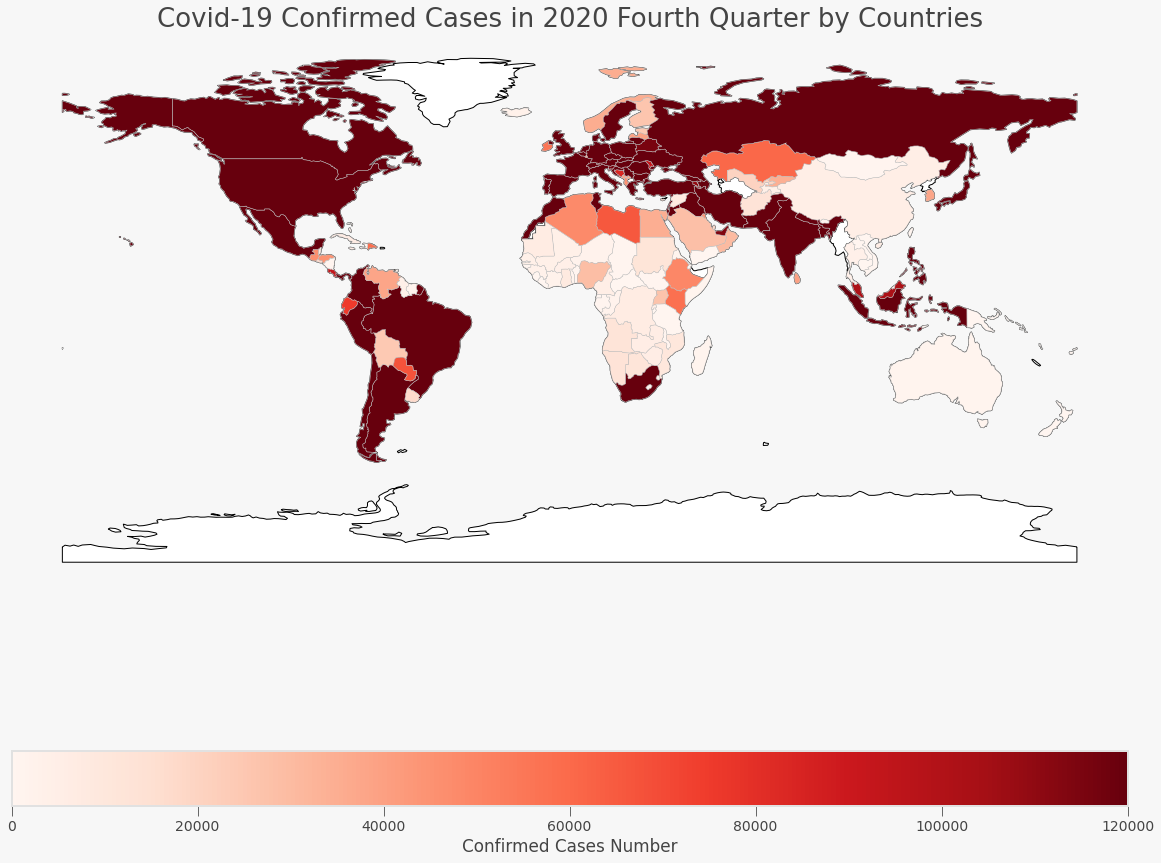

In [14]:
fig, gax = plt.subplots(figsize=(20, 20))
world.plot(ax=gax, edgecolor='black',color='white')

# Plot the covid-19 data to color

all_gbqt_map.plot(column=pd.to_datetime('2020-12-31'), cmap='Reds', ax=gax, linewidth=0.5, edgecolor='0.8', 
                  legend=True, legend_kwds={'label': "Confirmed Cases Number",'orientation': "horizontal"}, 
                  norm=plt.Normalize(vmin=0, vmax=120000))

# Add text to let people know what we are plotting
gax.set_title('Covid-19 Confirmed Cases in 2020 Fourth Quarter by Countries', fontsize = 26)

# I don't want the axis with long and lat
plt.axis('off')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

plt.show()

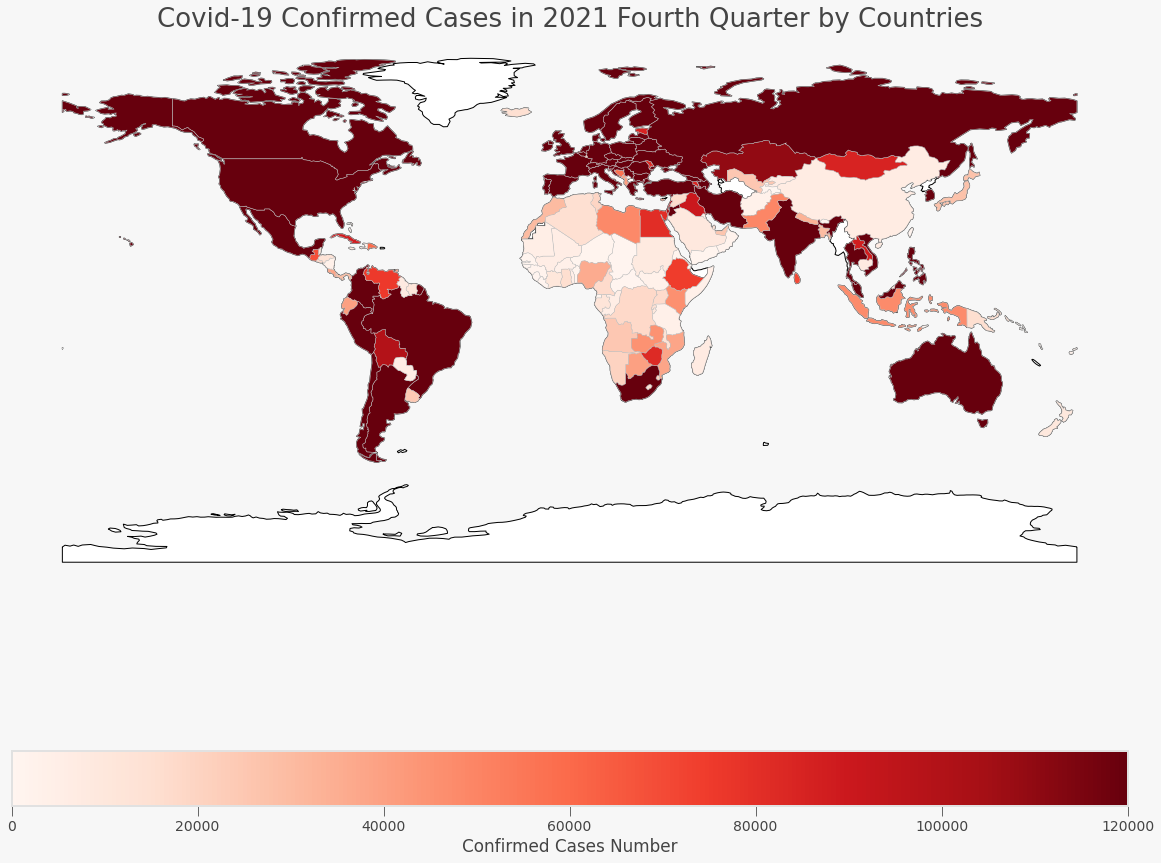

In [15]:
fig, gax = plt.subplots(figsize=(20, 20))
world.plot(ax=gax, edgecolor='black',color='white')

# Plot the covid-19 data to color

all_gbqt_map.plot(column=pd.to_datetime('2021-12-31'), cmap='Reds', ax=gax, linewidth=0.5, edgecolor='0.8', 
                  legend=True, legend_kwds={'label': "Confirmed Cases Number",'orientation': "horizontal"}, 
                  norm=plt.Normalize(vmin=0, vmax=120000))

# Add text to let people know what we are plotting
gax.set_title('Covid-19 Confirmed Cases in 2021 Fourth Quarter by Countries', fontsize = 26)

# I don't want the axis with long and lat
plt.axis('off')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

plt.show()

Here is the link for full-version map: https://drive.google.com/file/d/1TFFzT_ZwX5ZMnbHdUMc60x4GS-e0zNr-/view?usp=sharing

I mapped the cumulative number of confirmed cases in each country quarterly. This report chose not to map the x variable because vaccine rates in all countries increase over time. Thus, we can determine the relationship between the vaccination rate and the number of confirmed cases by comparing the map of confirmed cases at different times. Therefore, additional maps of vaccination rates are unnecessary and would not improve the readability of the maps.

Time is the independent variable in these maps, and the number of cases is the dependent variable. The two maps in the report represent the global number of confirmed Covid-19 cases in the fourth quarter of 2020 and the fourth quarter of 2021, respectively. At the end of 2020, the Covid-19 vaccine has just been produced, and people have not yet started to inoculate. In contrast, in the fourth quarter of 2021, most countries started to roll out the Covid-19 vaccine and have a relatively high vaccination rate. By comparing the maps for the same period in different years, we can estimate the effect brought by the vaccine.

However, from the two maps, we do not observe a significant decrease in the number of confirmed cases. This may be due to the diminished effectiveness of the Covid-19 vaccine against new variants of the virus, or it may be due to other factors. To better explore the effect of the vaccine, we need to further control for other variables.

# Project 3

## Main Message for Project 3


## Discussion
To reduce the influence of other factors on the number of confirmed Covid-19 cases and to obtain a more accurate relationship between the vaccination rate and the confirmed cases, the best approach is to control for other variables. Intuitively, the temperature changes may impact the spread of Covid-19. Second, the new Covid-19 variants may increase the virus's transmissibility. Third, the cancellation of the lockdown policies may also increase the number of confirmed cases. Therefore, these data are crucial for our subsequent regression analysis.

The Wikipedia page (https://en.wikipedia.org/wiki/List_of_cities_by_average_temperature) has several tables containing monthly average temperature statistics for each country. However, this table is large, and some countries are divided into multiple regions. Web scraping can quickly convert the page's content into a dataframe and quickly group and calculate them by country. For the Covid-19 variants and lockdown policies information, we could also get them all at once on the Wikipedia page. It is an excellent idea to scrap the variants information (https://en.wikipedia.org/wiki/Variants_of_SARS-CoV-2) but not the lockdown policies (https://en.wikipedia.org/wiki/COVID-19_lockdowns#Table_of_pandemic_lockdowns). The lockdown table is massive and contains a mass of complicated information we do not need. For example, we only need to know the six selected countries for our analysis, but there are too many countries in the table, and it is hard to do the data cleaning. Besides, many countries have different lockdown policies in different provinces or states, but our vaccination and confirmed cases data is based on the country level. So, it is hard to judge which information we need without manually select. Therefore, this report will use web-scraping to get the temperature and Covid-19 variants tables.

To combine the web-scraping data with our previous data, first, I will put the monthly temperature, the monthly number of confirmed Covid-19 cases, and vaccination rates for the six selected countries into the one dataframe. Then, I will plot a graph comparing the trend in temperature with the number of confirmed cases number for each country. Subsequently, I will present information on the Covid-19 variants in preparation for later regression analysis. 

For these tables, this study does not require running the program over time to generate the data unless it is desired to make a long-term pandemic prediction for the number of confirmed cases at a later time. For the temperature data, we took the historic average temperature of each month, and these temperatures do not change much from year to year. For data on new Covid-19 variants and lockdown policies, we do not know when new variants and policies will emerge, but we can generate new data in the future as we get more information. If there are new dramatic changes in the pandemic in the future, we can collect these data to run new regression analyses and predictions.

## Web-Scraping

In [16]:
#Get the web page.
temp_url = 'https://en.wikipedia.org/wiki/List_of_cities_by_average_temperature'
response1 = requests.get(temp_url)

soup_object1 = BeautifulSoup(response1.content)

#Create a new data frame and a regex expression.
temp_df = pd.DataFrame(columns = ['Country', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
regex1 = re.compile(r'([([](.*?)[\)\]])') 

#Get the table we need in the website. Note that the data is in several tables and we need all of them.
data_table_list = soup_object1.find_all('table', 'wikitable plainrowheaders sortable')

#Iterate each tables.
for t in data_table_list:
    #Find all rows in the table.
    all_values1 = t.find_all('tr')
    #Create a temporary dataframe to record each table in list.
    temp = pd.DataFrame(columns = ['Country', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ix = 0 # Initialise index to zero

    #Iterate each row in the table.
    for row in all_values1[1:]:
        values = row.find_all('td') # Extract all elements with tag <td>
        #Get the value we need. Note that we will strip some annotation and unnecessary information.
        country = re.sub(regex1, '', values[0].text.strip('\n'))
        #Note that we need to convert the value type to float so we can calculate them later.
        Jan = float(re.sub(regex1, '', values[2].text.strip('\n')).replace('−', '-'))
        Feb = float(re.sub(regex1, '', values[3].text.strip('\n')).replace('−', '-'))
        Mar = float(re.sub(regex1, '', values[4].text.strip('\n')).replace('−', '-'))
        Apr = float(re.sub(regex1, '', values[5].text.strip('\n')).replace('−', '-'))
        May = float(re.sub(regex1, '', values[6].text.strip('\n')).replace('−', '-'))
        Jun = float(re.sub(regex1, '', values[7].text.strip('\n')).replace('−', '-'))
        Jul = float(re.sub(regex1, '', values[8].text.strip('\n')).replace('−', '-'))
        Aug = float(re.sub(regex1, '', values[9].text.strip('\n')).replace('−', '-'))
        Sep = float(re.sub(regex1, '', values[10].text.strip('\n')).replace('−', '-'))
        Oct = float(re.sub(regex1, '', values[11].text.strip('\n')).replace('−', '-'))
        Nov = float(re.sub(regex1, '', values[12].text.strip('\n')).replace('−', '-'))
        Dec = float(re.sub(regex1, '', values[13].text.strip('\n')).replace('−', '-'))
        #Add the value we need into our temporary dataframe.
        temp.loc[ix] = [country, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec]
        #Increase the index number.
        ix += 1
    #Merge every temporary dataframe together to get a whole dataframe.
    temp_df = pd.concat([temp_df, temp])

temp_df.reset_index(drop=True, inplace=True)
#Group the dataframe by country and calculate the mean monthly temperature for each country.
temp_df = temp_df.groupby('Country').mean()
temp_df = temp_df.T

Since the temperatures are divided into multiple tables by region, we need to iterate through each table and merge them into one complete table. After that, we grouped the table by country. For countries with multiple information of provinces or states, we take the average of their temperatures to obtain the average temperature at the national level. The explanation for each step of code is in the annotation.

In [17]:
#Group our previous dataframe by month.
per_day.reset_index(inplace=True)
per_mon = per_day.set_index('date')
per_mon = per_mon.groupby(pd.Grouper(freq='M')).sum()
per_mon.reset_index(inplace=True)

#Merge the temperature dataframe with our previous cases number and vaccination dataframe.
for c in per_mon.columns[1:7]:
    per_mon[c + '_temp'] = np.nan
    for d in per_mon['date']:
        mon = d.month
        if c == 'United States of America':
            temp = temp_df['United States'][mon - 1]
        else:
            temp = temp_df[c][mon - 1]
        per_mon.loc[per_mon['date'] == d, c + '_temp'] = temp
per_mon.head()

,date,China,Switzerland,United States of America,United Kingdom,India,Russia,China_temp,Switzerland_temp,United States of America_temp,United Kingdom_temp,India_temp,Russia_temp
0,2020-09-30,326.0,5846.0,661201.0,82291.0,1382348.0,106361.0,20.741667,14.1,21.848077,14.35,28.366667,10.176923
1,2020-10-31,821.0,100969.0,1917983.0,558947.0,1871498.0,435468.0,15.241667,9.9,16.176923,10.90,27.300000,3.092308
2,2020-11-30,1536.0,172821.0,4470328.0,618941.0,1278727.0,669669.0,8.683333,4.4,10.363462,7.35,23.800000,-5.500000
3,2020-12-31,3061.0,125224.0,6563774.0,862499.0,823900.0,851411.0,2.991667,1.4,5.540385,4.85,20.266667,-11.107692
4,2021-01-31,4100.0,69024.0,6152391.0,1331952.0,470901.0,681001.0,1.191667,0.3,4.578846,4.70,19.200000,-13.223077


## Visualization

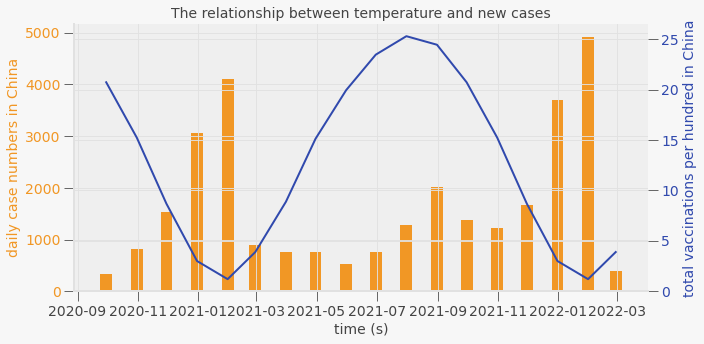

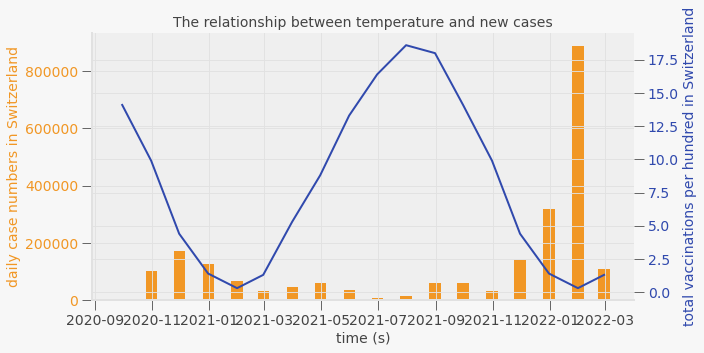

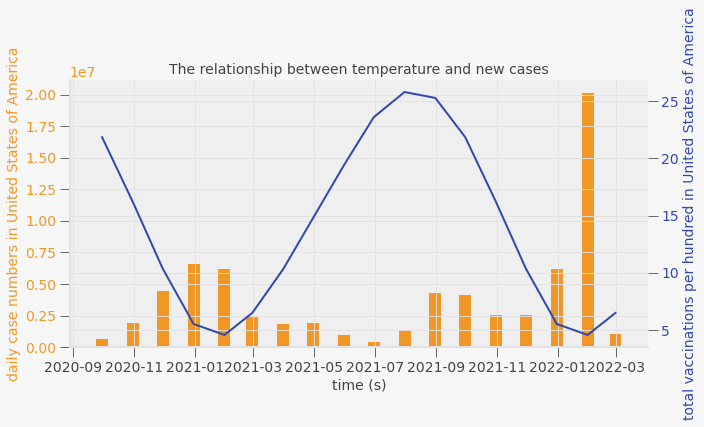

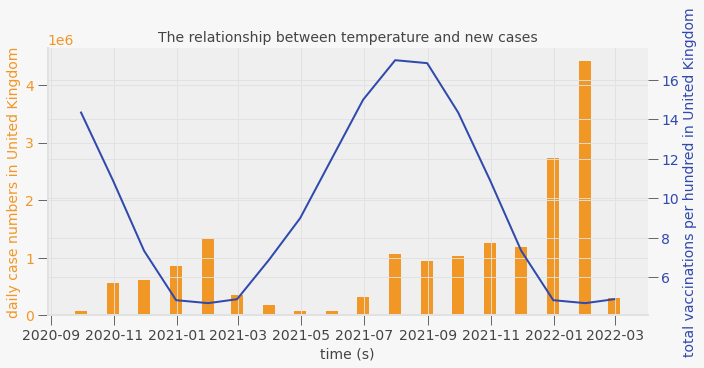

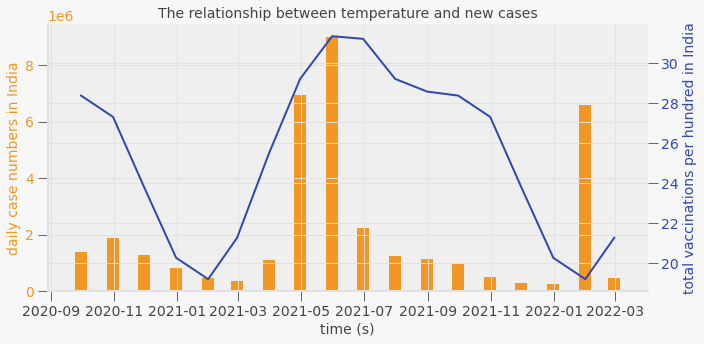

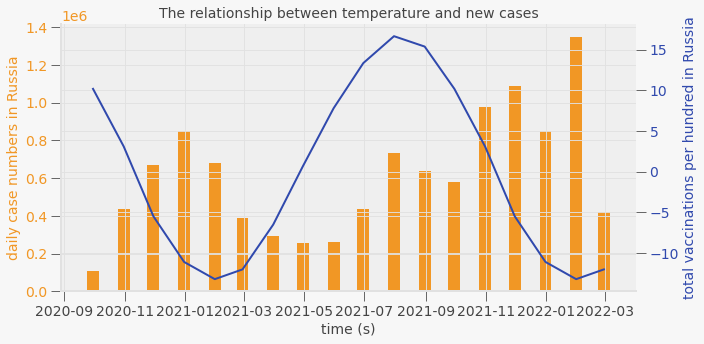

In [18]:
for c in rsch_countries:
    fig, ax1 = plt.subplots(figsize=(10, 5))

    color = '#f19725'
    ax1.set_xlabel('time (s)', fontsize=14)
    ax1.set_ylabel('daily case numbers in ' + c, color=color, fontsize=14)
    ax1.bar(per_mon['date'], per_mon[c], color=color, width=12)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax1.set_title('The relationship between temperature and new cases', fontsize=14)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = '#3049ad'

    ax2.set_ylabel('total vaccinations per hundred in ' + c, color=color, fontsize=14)  # we already handled the x-label with ax1
    ax2.plot(per_mon['date'], per_mon[c + '_temp'], color=color, linewidth=2)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

From the graph, we can observe that the temperature changes in China, India, and Russia are very similar to the trend of the number of confirmed Covid-19 cases. Specifically, the number of cases increased in the months with higher temperatures and decreased in the months with lower temperatures. This trend will be particularly evident from April to November 2021. However, the trend between January to March 2021 and December 2021 to February 2022 does not seem positively correlated. Meanwhile, there seems to be little correlation between temperature and the number of confirmed cases for Switzerland, the US, and the UK.

Therefore, we cannot exclude the influence of weather on the spread of the Covid-19, nor can we determine a specific relationship between them. However, we can infer that higher temperatures may have led to an increase in confirmed cases. To understand the exact relationship between them, we need to conduct multiple regression analyses in the next step.

In [19]:
var_url = 'https://en.wikipedia.org/wiki/Variants_of_SARS-CoV-2'
response2 = requests.get(var_url)

soup_object2 = BeautifulSoup(response2.content)

data_table2 = soup_object2.find_all('table', 'wikitable sortable')[0]
all_values2 = data_table2.find_all('tr')

var_df = pd.DataFrame(columns = ['WHO label', 'Date of designation', 'transmissibility']) # Create an empty dataframe
regex1 = re.compile(r'([([](.*?)[\)\]])') 
regex2 = re.compile(r'\d')
ix = 0 # Initialise index to zero

for row in all_values2[1:]:
    values = row.find_all('td') # Extract all elements with tag <td>
    if len(values) != 0:
        # Pick only the text part from the <td> tag
        who = re.sub(regex1, '', values[0].text.strip('\n'))
        date = re.sub(regex1, '', values[5].text.strip('\n'))
        date = pd.to_datetime(date)
        trans = re.sub(regex1, '', values[8].text.strip('\n'))
    
        var_df.loc[ix] = [who, date, trans] # Store it in the dataframe as a row
    ix += 1
    
var_df = var_df.sort_values('Date of designation', axis=0, ascending=True)
var_df.reset_index(drop=True, inplace=True)
var_df

,WHO label,Date of designation,transmissibility
0,Alpha,2020-12-18,+29%
1,Beta,2021-01-14,+25%
2,Gamma,2021-01-15,+38%
3,Delta,2021-05-06,+97%
4,Omicron,2021-11-26,Possibly increased


Using the table above, we find that each Covid-19 variant leads to an increase in transmissibility. Note that January and December 2021 correspond to the emergence of the beta and ormicron variants, respectively, which may explain why the trends in weather changes and the number of confirmed cases are no longer similar during this period. 

# Regression

For regression analysis, I combined the above data into a new dataframe. Among the data, the different variants and countries are encoded in the form of dummy variables, where 1 means yes and 0 means no. Also, since dates cannot be used as regressions, I use September 15, 2020 as the starting point, coded as 0, and subsequent dates are coded as integers in the form of difference in days. For example, 20 represents the 20th day after September 15, 2020. After that, we can compare the number of cases per day with the difference in days.

In [20]:
#Create a new dataframe for the regression.
mult_reg = pd.DataFrame(columns=['country', 'date', 'total_vaccinations_per_hundred'])

#Get the vaccination rate, country name, and date.
for c in rsch_countries:
    c_df = pd.DataFrame(vacc.loc[vacc['country'] == c, ['country', 'date', 'total_vaccinations_per_hundred']])
    c_df['total_vaccinations_per_hundred'].fillna(method="ffill", inplace=True)
    c_df['daily_cases'] = np.nan
    for d in c_df['date']:
        try:
            num = float(per_day.loc[per_day['date'] == d, c])
            c_df.loc[c_df['date'] == d, 'daily_cases'] = num
        except:
            c_df.loc[c_df['date'] == d, 'daily_cases'] = np.nan    
    mult_reg = pd.concat([mult_reg, c_df])

#Clean the missing value and reset the index.
mult_reg['daily_cases'].fillna(method="ffill", inplace=True)
mult_reg = mult_reg.reset_index(drop=True)

#Add the data one quarter before vaccination into the dataframe.
ix = len(mult_reg.index)
for c in rsch_countries:
    list1 = []
    for d in mult_reg.loc[mult_reg['country'] == c, 'date']:
        list1.append(d)
    for d in per_day['date']:
        if d not in list1:
            ix += 1
            vacc_value = 0
            cases = float(per_day.loc[per_day['date'] == d, c])
            mult_reg.loc[ix] = [c, d, vacc_value, cases]
mult_reg.sort_values(['country', 'date'], inplace=True)

#Add the temperatures into dataframe.
mult_reg['temp'] = np.nan
for i in mult_reg.index:
    d = mult_reg['date'][i]
    c = mult_reg['country'][i]
    mon = d.month
    if c == 'United States of America':
        temp = temp_df['United States'][mon - 1]
    else:
        temp = temp_df[c][mon - 1]
    mult_reg['temp'][i] = temp

#Add the variants of Covid-19 into dataframe as dummy variables.
for i in var_df.index:
    name = var_df['WHO label'][i]
    mult_reg[name] = 0
    if i < len(var_df.index) - 2:
        begin = var_df['Date of designation'][i]
        end = pd.to_datetime('2022-3-9')
        for d in mult_reg['date']:
            if begin <= d and d <= end:
                mult_reg.loc[mult_reg['date'] == d, name] = 1
    else:
        begin = var_df['Date of designation'][i]
        for d in mult_reg['date']:
            if begin <= d:
                mult_reg.loc[mult_reg['date'] == d, name] = 1
mult_reg.reset_index(drop=True, inplace=True)
mult_reg['total_vaccinations_per_hundred'] = mult_reg['total_vaccinations_per_hundred'].astype('float64')

#Add the new column to capture the change of time.
mult_reg['date'] = pd.to_datetime(mult_reg['date'])
mult_reg['time'] = mult_reg['date'] - pd.to_datetime('2020-09-15')
mult_reg['time'] = mult_reg['time'].dt.days.astype('int64')

mult_reg['lockdown'] = 0
for i in mult_reg.index:
    if mult_reg['country'][i] == 'India':
        d = mult_reg['date'][i]
        if d <= pd.to_datetime('2021-05-19') and d>= pd.to_datetime('2021-04-30'):
            mult_reg['lockdown'][i] = 1
    elif mult_reg['country'][i] == 'Russia':
        if d <= pd.to_datetime('2021-11-04') and d>= pd.to_datetime('2021-10-28'):
            mult_reg['lockdown'][i] = 1
    elif mult_reg['country'][i] == 'Switzerland':
        if d <= pd.to_datetime('2021-03-01') and d>= pd.to_datetime('2021-01-18'):
            mult_reg['lockdown'][i] = 1
    elif mult_reg['country'][i] == 'United Kingdom':
        if d <= pd.to_datetime('2021-03-29') and d>= pd.to_datetime('2020-12-26'):
            mult_reg['lockdown'][i] = 1
        elif d <= pd.to_datetime('2020-12-06') and d>= pd.to_datetime('2020-11-16'):
            mult_reg['lockdown'][i] = 1

#Change the country name column into dummy varuables.
mult_reg['country_copy'] = mult_reg['country'] 
mult_reg = pd.get_dummies(mult_reg, columns=['country'], drop_first=True)
mult_reg.rename(columns={'country_United Kingdom':'country_United_Kingdom', 
                 'country_United States of America':'country_United_States_of_America'}, inplace=True)

In [21]:
mult_reg['ln_cases'] = np.log(mult_reg['daily_cases'] + 1)
mult_reg['ln_vacc'] = np.log(mult_reg['total_vaccinations_per_hundred'] + 1)
mult_reg.head()

,date,total_vaccinations_per_hundred,daily_cases,temp,Alpha,Beta,Gamma,Delta,Omicron,time,lockdown,country_copy,country_India,country_Russia,country_Switzerland,country_United_Kingdom,country_United_States_of_America,ln_cases,ln_vacc
0,2020-09-15,0.0,16.0,20.741667,0,0,0,0,0,0,0,China,0,0,0,0,0,2.833213,0.0
1,2020-09-16,0.0,18.0,20.741667,0,0,0,0,0,1,0,China,0,0,0,0,0,2.944439,0.0
2,2020-09-17,0.0,41.0,20.741667,0,0,0,0,0,2,0,China,0,0,0,0,0,3.737670,0.0
3,2020-09-18,0.0,17.0,20.741667,0,0,0,0,0,3,0,China,0,0,0,0,0,2.890372,0.0
4,2020-09-19,0.0,23.0,20.741667,0,0,0,0,0,4,0,China,0,0,0,0,0,3.178054,0.0


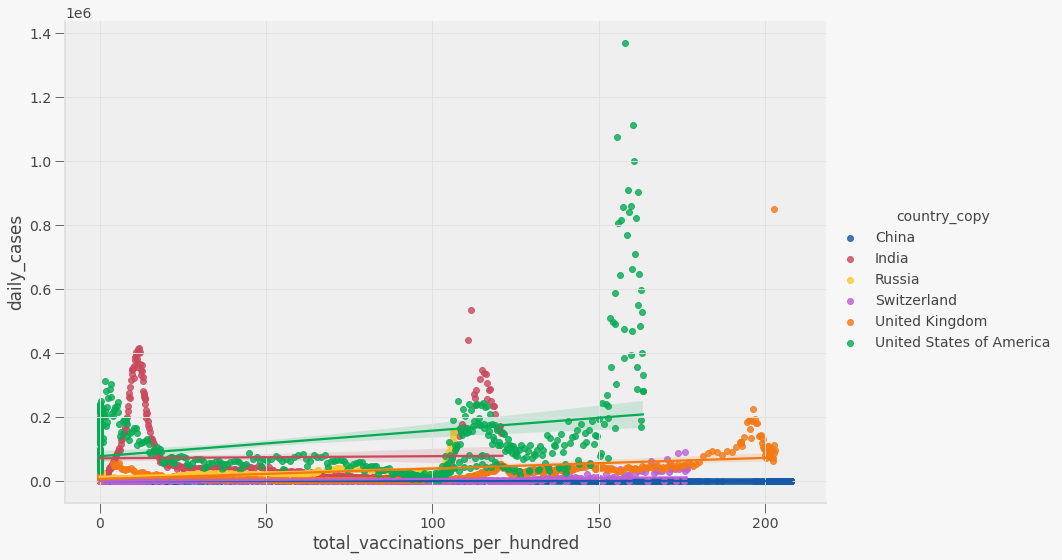

In [22]:
sns.lmplot(x="total_vaccinations_per_hundred", y="daily_cases", data=mult_reg, hue='country_copy', height=8, aspect=1.5)

I visualized the vaccination rates and daily cases number before the formal regression analysis. In this graph, the six researched countries are analyzed separately. However, because the data are highly volatile and vary from country to country, it is difficult to infer a general relationship between vaccination rates and daily cases. To make the data look more reasonable, I then use log-log regression to plot the new graph.

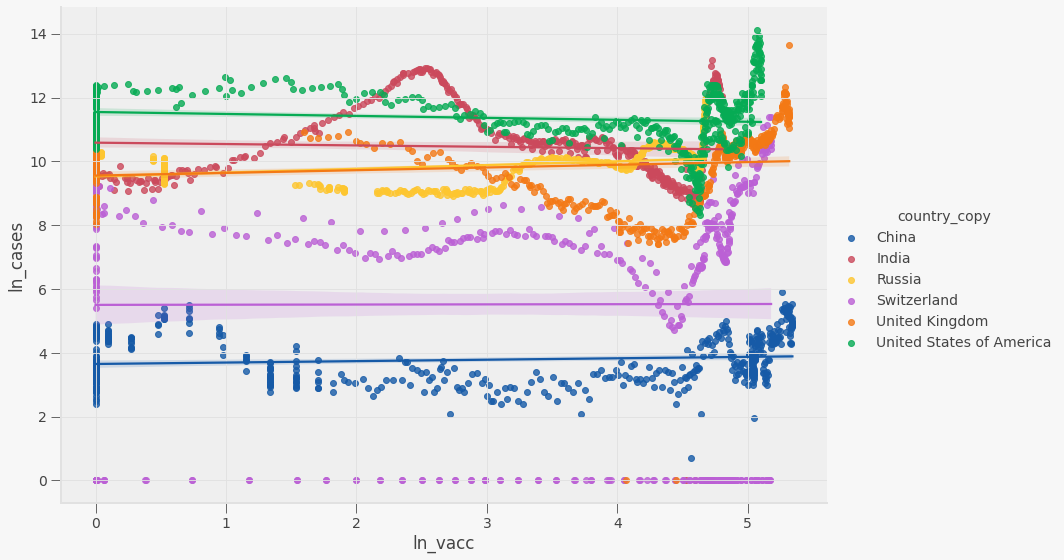

In [23]:
sns.lmplot(x="ln_vacc", y="ln_cases", data=mult_reg, hue='country_copy', height=8, aspect=1.5)

In log-log regression, the data tends to be stable. With the exception of Switzerland, vaccination rates in other countries appear to have a slight linear relationship in the daily number of cases. It is important to note that since we are taking logarithms of the data, the graph’s unit is not interpreted in the original units, but in percentages.

For the regression, I created four different models to compare. Each model use OLS linear regression, but model 2 and model 4 using the log-log regression instead of the original regression.

For Model 1 and Model 2, I added temperature, time, lockdown or not, variants status and different countries into x variable, among which the influence of temperature, time and different countries on the number of daily cases can be seen in the previous section’s graphs. We know from the previous table that different variants increase the infectivity of Covid-19, and lockdown affect residents' gathering behavior, so I also take these two variables into account. For Model 3 and Model 4, in addition to the above variables, I have added the multiplication of vaccination rates with different dummy variables. This measures whether different variants and countries affect the slope of the regression.

In [24]:
#Another way to print the OLS regression results at once.
#Provided in the lecture.
import statsmodels.formula.api as smf

formula1 = 'daily_cases~total_vaccinations_per_hundred + Alpha + Beta + Gamma + Delta + Omicron + country_India + country_Russia \
+ country_Switzerland + country_United_Kingdom + country_United_States_of_America+ lockdown + temp + time'
formula2 = 'ln_cases~ln_vacc + Alpha + Beta + Gamma + Delta + Omicron + country_India + country_Russia \
+ country_Switzerland + country_United_Kingdom + country_United_States_of_America+ lockdown + temp + time'
formula3 = 'daily_cases~total_vaccinations_per_hundred + total_vaccinations_per_hundred*country_India + \
total_vaccinations_per_hundred*country_Russia + total_vaccinations_per_hundred*country_Switzerland + \
total_vaccinations_per_hundred*country_United_Kingdom + total_vaccinations_per_hundred*country_United_States_of_America + \
total_vaccinations_per_hundred*Alpha + total_vaccinations_per_hundred*Beta + total_vaccinations_per_hundred*Gamma + \
total_vaccinations_per_hundred*Delta + total_vaccinations_per_hundred*Omicron + lockdown + temp + time'
formula4 = 'ln_cases~ln_vacc + ln_vacc*country_India + ln_vacc*country_Russia + ln_vacc*country_Switzerland + \
ln_vacc*country_United_Kingdom + ln_vacc*country_United_States_of_America + ln_vacc*Alpha + ln_vacc*Beta + ln_vacc*Gamma + \
ln_vacc*Delta + ln_vacc*Omicron + lockdown + temp + time'
#Do not need to add const because the table give the intercept for us.

flist = [formula1, formula2, formula3, formula4]

result_list = []
for i in flist:
    reg = smf.ols(i, data = mult_reg).fit()
    result_list.append(reg)
    print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:            daily_cases   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     149.6
Date:                Sun, 17 Apr 2022   Prob (F-statistic):               0.00
Time:                        00:01:07   Log-Likelihood:                -38447.
No. Observations:                3046   AIC:                         7.692e+04
Df Residuals:                    3031   BIC:                         7.701e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [25]:
info_dict={'AIC' : lambda x: f"{x.aic:.2f}", 
           'BIC' : lambda x: f"{x.bic:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}
#AIC, BIC, adj. R^2, F in final project


results_table = summary_col(results=result_list, float_format='%0.3f', stars = True, 
                            model_names=['Model 1', 'Model 2', 'Model 3', 'Model 4'], info_dict=info_dict, 
                            regressor_order=['Intercept', 'total_vaccinations_per_hundred', 'ln_vacc', 'temp', 'time', 'lockdown', 
                                             'Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron', 'country_Switzerland', 'country_Russia', 
                                             'country_India', 'country_United_Kingdom', 'country_United_States_of_America',
                                            'total_vaccinations_per_hundred:Alpha', 'total_vaccinations_per_hundred:Beta',
                                            'total_vaccinations_per_hundred:Gamma', 'total_vaccinations_per_hundred:Delta',
                                            'total_vaccinations_per_hundred:Omicron', 
                                            'total_vaccinations_per_hundred:country_Switzerland',
                                            'total_vaccinations_per_hundred:country_Russia', 
                                            'total_vaccinations_per_hundred:country_India',
                                            'total_vaccinations_per_hundred:country_United_Kingdom', 
                                            'total_vaccinations_per_hundred:country_United_States_of_America'])

#results_table.add_title('Table 2 - OLS Regressions')

print(results_table)


                                                                   Model 1     Model 2     Model 3     Model 4  
----------------------------------------------------------------------------------------------------------------
Intercept                                                       -25416.866*** 3.393***  -46025.150*** 3.311***  
                                                                (6194.511)    (0.163)   (7591.286)    (0.209)   
total_vaccinations_per_hundred                                  -447.935***             343854.059              
                                                                (72.195)                (290746.738)            
ln_vacc                                                                       -0.491***               2.688     
                                                                              (0.076)                 (7.645)   
temp                                                            435.227       0.001     984.915

Due to the large number of variables, the above image contains only important data. A complete comparison is in the appendix. Comparing the four models, we found that log-log regression (models 2 and 4) had significantly higher R-squared values and lower AIC and BIC values. Therefore, it can be concluded that log-log regression is better than simple linear regression to explain the change in the number of daily cases. Comparing model 2 and model 4, although model 4 contains more variables, we can find that most of these variables are not statistically significant, and the results are no better than model 2. We also noted that in model 2, for every 1% increase in vaccination rate, the number of cases decreased by approximately 0.49 percent. While this is not an economically significant number, it does demonstrate the effectiveness of vaccines. Model 4 has a more complex interpretation where we need to add the coefficient of the vaccine rate to the coefficient of the product of the vaccine rate for different variants or countries, and it is not statistically significant. Therefore, I believe that Model 2 better explained the impact of vaccination rate on the number of daily cases than model 4.

However, despite this, I still need claim that our model got very large AIC and BIC values, which means that our model may have serious errors. And since we only have observational data, not experimental data, causality cannot be inferred from it. Therefore, this regression analysis can only be used for preliminary judgment and cannot draw definite conclusions.

# Machine Learning

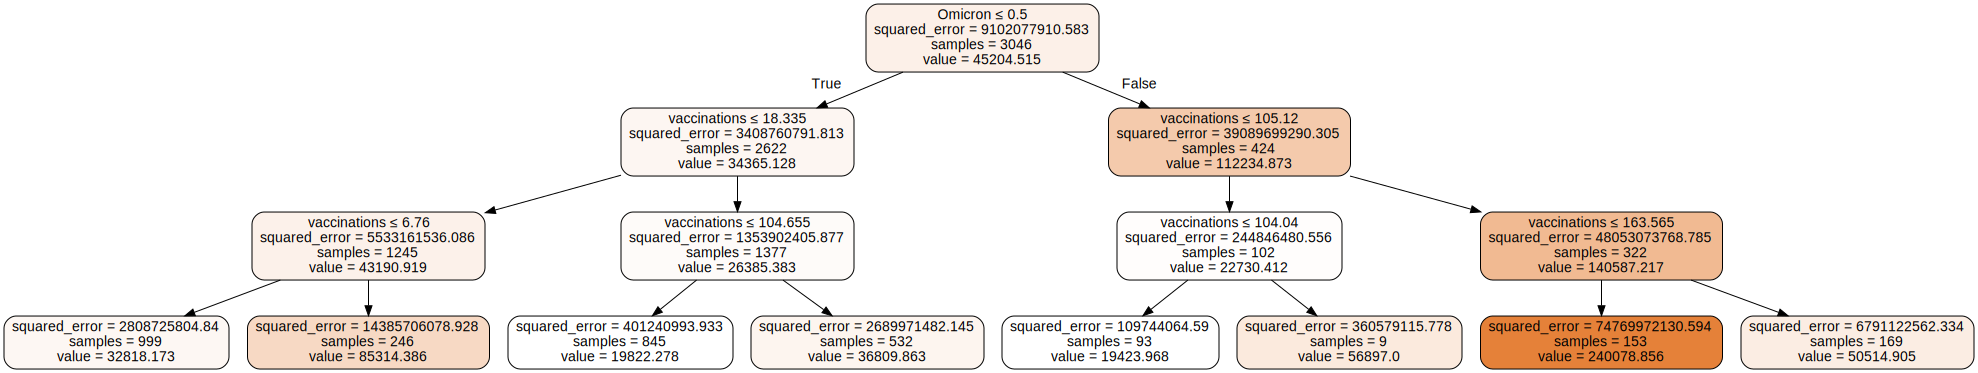

In [26]:
colors = qeds.themes.COLOR_CYCLE
plotly_template = qeds.themes.plotly_template()

# Simulate some data and plot it
Xsim = np.column_stack((mult_reg['total_vaccinations_per_hundred'], mult_reg['Omicron']))
ysim = mult_reg['daily_cases']
fitted_tree = tree.DecisionTreeRegressor(max_depth=3).fit(Xsim,ysim)
tree_graph = tree.export_graphviz(fitted_tree, out_file=None,
                                  feature_names=["vaccinations", "Omicron"],
                                  filled=True, rounded=True,
                                  special_characters=True)
display(graphviz.Source(tree_graph))

Omicron is a variable because in response analysis, I found that there was a significant increase in the number of cases in each country around the time Omicron appeared, so it not only has an important influence on the prediction, but also represents whether the prediction was made before or after Omicron appeared. We can confirm from the decision tree that the predicted number of diagnoses increased significantly when Omicron was present. However, MSE is huge, which means our decision tree cannot predict daily cases very accurately. That's because we have so many variables that it's hard to make predictions just from Omicron and vaccination rates.

# Conclusion and Future Steps

To summarize, we can conclude that after controlling other variables, for every 1% increase in vaccination rate, the number of cases decreased by approximately 0.49 percent. Also, the emergence of different variants must increase the number of confirmed Covid-19 cases, while the increase in temperature may also lead to an increase in confirmed cases. This could explain why there is an upward trend in the number of confirmed cases in the first two months of the emergence of the Covid-19 variant, and there is a downward trend in the number of confirmed cases for specific periods as the vaccination rate increases. 